In [2]:

import logging
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.fft as fft
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import scipy.io as sio
# import h5py

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import re


In [4]:
WD = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/'
os.chdir(WD)
print(os.getcwd())

/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx


In [11]:
class TimeDataSetLinearResiduals(torch.utils.data.Dataset):
    def __init__(self, X, t_grid, x_grid):
        super(TimeDataSetLinearResiduals, self).__init__()
        assert X.shape[1] == t_grid.shape[-1]
        self.X = torch.tensor(X, dtype=torch.cfloat)
        self.t = torch.tensor(t_grid.flatten(), dtype=torch.float)
        self.x_grid = torch.tensor(x_grid, dtype=torch.float).view(-1, 1)
        self.n_tsteps = self.t.shape[0] - 1
        self.n_batches = self.X.shape[0]
        self.dataset_len = self.n_tsteps * self.n_batches
        n_gridpoints = self.X.shape[-1]

        # Sampling frequencies: spatial interval is [-pi, pi]
        # There are N=1024 samples
        # dx = 2*pi / 1024
        dx = 2 * np.pi / n_gridpoints
        w_numbers = 2 * np.pi * torch.fft.fftfreq(n_gridpoints, d=dx)
        self.wave_numbers = torch.square(w_numbers)
        self.make_linear_part()



    def make_linear_part(self):

        lin_part = torch.zeros_like(self.X)
        for b in range(self.n_batches):
            ic_b = self.X[b,0]
            for t_step, t_val in enumerate(self.t):
                # print(t_step, t_val)
                lin_part[b,t_step] = self.linear_part(ic_b, t_val)
        self.linear_part_arr = lin_part

    def linear_part(self, x_0, t):
        # x_0 has shape (self.X.shape[-1],)
        # t is a float
        x_0_hat = torch.fft.fft(x_0)
        # exp(-i /2 * t * xi^2 )
        ee = -1j * t /2
        aa = torch.mul(self.wave_numbers, ee)
        exp_term = torch.exp(aa)
        exp_term_2 = np.exp(aa.numpy())
        a = torch.mul(exp_term, x_0_hat)
        out = torch.fft.ifft(a)
        return out

    def make_x_train(self, X, single_batch=False):
        # X has shape (nbatch, 1, grid_size)
        n_batches = X.shape[0] if len(X.shape) > 1 else 1

        # Convert to tensor
        X_input = torch.view_as_real(torch.tensor(X, dtype=torch.cfloat))


        if single_batch:
            X_input = torch.cat((X_input, self.x_grid), dim=1)
        else:
            x_grid_i = self.x_grid.repeat(n_batches, 1, 1)
            X_input = torch.cat((X_input.view((n_batches, -1, 2)), x_grid_i), axis=2)

        return X_input

    def __getitem__(self, idx):
        idx_original = idx
        t_idx = int(idx % self.n_tsteps) + 1
        idx = int(idx // self.n_tsteps)
        batch_idx = int(idx % self.n_batches)
        x = self.make_x_train(self.X[batch_idx, 0], single_batch=True) #.reshape(self.output_shape)
        y = self.X[batch_idx, t_idx] #.reshape(self.output_shape)
        t = self.t[t_idx]
        lin_part = self.linear_part_arr[batch_idx, t_idx]
        return x,y,t,lin_part

    def __len__(self):
        return self.dataset_len

    def __repr__(self):
        return "TimeDataSetLinearResiduals with length {}, n_tsteps {}, n_batches {}".format(self.dataset_len,
                                                                                            self.n_tsteps,
                                                                                            self.n_batches)


In [9]:
DATA_FP = '/local/meliao/projects/fourier_neural_operator/data/2021-06-24_NLS_data_04_test.mat'

In [5]:
d = sio.loadmat(DATA_FP)
X = d['output']
t = d['t']
x_grid = d['x']

In [21]:
fake_X = torch.zeros((1,400,1024), dtype=torch.cfloat)
fake_X[0,0] = torch.sin(torch.linspace(-np.pi, np.pi, 1024))
fake_t = torch.linspace(0, (np.pi * 4), 400)
fake_x_grid = torch.linspace(-np.pi, np.pi, 1024)
tt = TimeDataSetLinearResiduals(fake_X, fake_t, fake_x_grid)

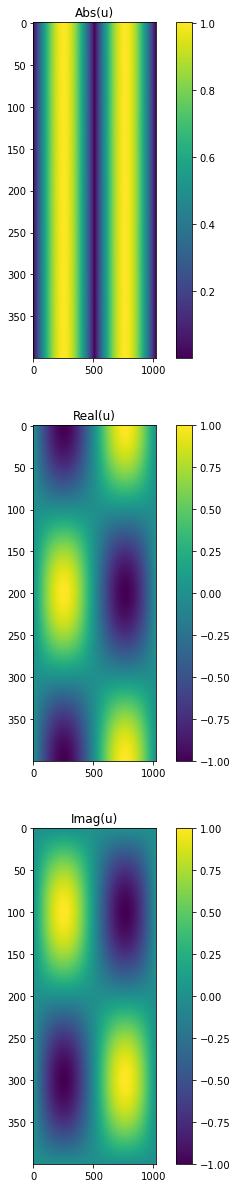

In [22]:
zz = tt.linear_part_arr[0]

def show_lin_solution(z):
    ASPECT=7
    fig, ax = plt.subplots(3,1)
    fig.set_size_inches(7,21)
    im_0 = ax[0].imshow(np.abs(z), aspect=ASPECT)
    fig.colorbar(im_0, ax=ax[0])
    ax[0].set_title("Abs(u)")

    im_1 = ax[1].imshow(np.real(z), aspect=ASPECT)
    fig.colorbar(im_1, ax=ax[1])
    ax[1].set_title("Real(u)")

    im_2 = ax[2].imshow(np.imag(z), aspect=ASPECT)
    fig.colorbar(im_2, ax=ax[2])
    ax[2].set_title("Imag(u)")
show_lin_solution(zz)

In [6]:
tt = TimeDataSetLinearResiduals(X, t, x_grid)

In [21]:
x_0_flat = torch.ones(1024)

In [26]:
def build_lin_soln(x_0, t_dset):
    out = np.zeros((100, 1024), dtype=np.cfloat)
    for i in range(100):
        t = i/100 * 2 * np.pi
        out[i] = t_dset.linear_part(x_0, t)
    return out

In [27]:
zz = build_lin_soln(x_0_flat, tt)

In [17]:
import matplotlib.pyplot as plt